# GMD Normalization and Correlation  - DESC Commisioning 30th April '19

In [1]:
import h5py;
from matplotlib import pyplot as plt
import numpy as np

from scipy.stats import kde

DAQ run with delay scan

In [2]:
runNumber = 28496

dataDir = '/asap3/fs-flash-o/gpfs/camp/2019/data/11007673/raw/hdf/by-run/'
hdfFilename = 'FLASH1_USER1-run'+str(runNumber)+'.h5'

gmdAveBdaAddr = '/FL1/Photon Diagnostic/GMD/Average energy/energy BDA (raw)'
gmdAveTunnelAddr = '/FL1/Photon Diagnostic/GMD/Average energy/energy tunnel (raw)'
gmdPulseResBdaAddr = '/FL1/Photon Diagnostic/GMD/Pulse resolved energy/energy BDA (raw)'
gmdPulseResTunnelAddr = '/FL1/Photon Diagnostic/GMD/Pulse resolved energy/energy tunnel (raw)'

print(dataDir+hdfFilename)

/asap3/fs-flash-o/gpfs/camp/2019/data/11007673/raw/hdf/by-run/FLASH1_USER1-run28496.h5


### Read GMD from h5 file 

In [3]:
hdfFile = h5py.File(dataDir+hdfFilename,'r')

gmdAveBda = hdfFile[gmdAveBdaAddr].value
gmdAveTunnel = hdfFile[gmdAveTunnelAddr].value
gmdPulseResBda = hdfFile[gmdPulseResBdaAddr].value
gmdPulseResTunnel = hdfFile[gmdPulseResTunnelAddr].value

/software/anaconda3/5.2/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


### Plot averaged GMD versus file index 

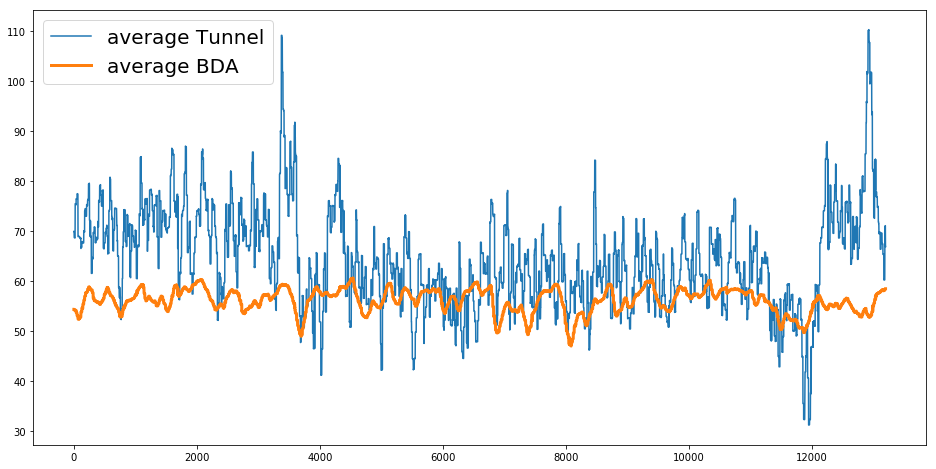

In [4]:
plt.figure(figsize=(16,8))
plt.plot(gmdAveTunnel, label = 'average Tunnel')
plt.plot(gmdAveBda, label = 'average BDA', lw = 3)
plt.legend(fontsize = 20);

### Plot averaged GMD versus file index 

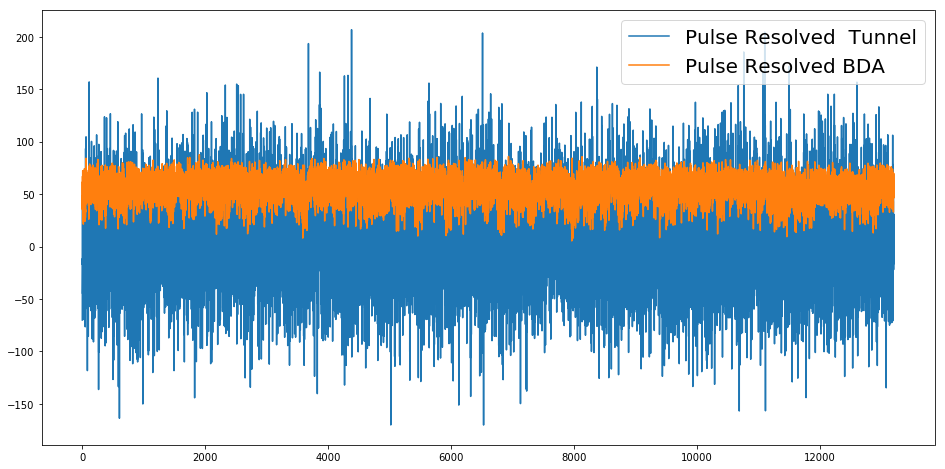

In [5]:
plt.figure(figsize=(16,8))
plt.plot(gmdPulseResTunnel, label = 'Pulse Resolved  Tunnel')
plt.plot(gmdPulseResBda, label = 'Pulse Resolved BDA')
plt.legend(fontsize = 20);

### <span style="color:red">negative values for pulse resolved GMD values in tunnel</span>

## check pulse resolved tunnel values for smaller than Zero

In [6]:
print('total number of values: ',len(gmdPulseResTunnel))
print('number of values smaller than Zero: ',len(gmdPulseResTunnel[gmdPulseResTunnel<0]))
print('number of NaNs: ', np.sum(np.isnan(gmdPulseResTunnel)))

total number of values:  13200
number of values smaller than Zero:  5714
number of NaNs:  5


/software/anaconda3/5.2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


## distribution of pulse resolved GMD values

/software/anaconda3/5.2/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/software/anaconda3/5.2/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


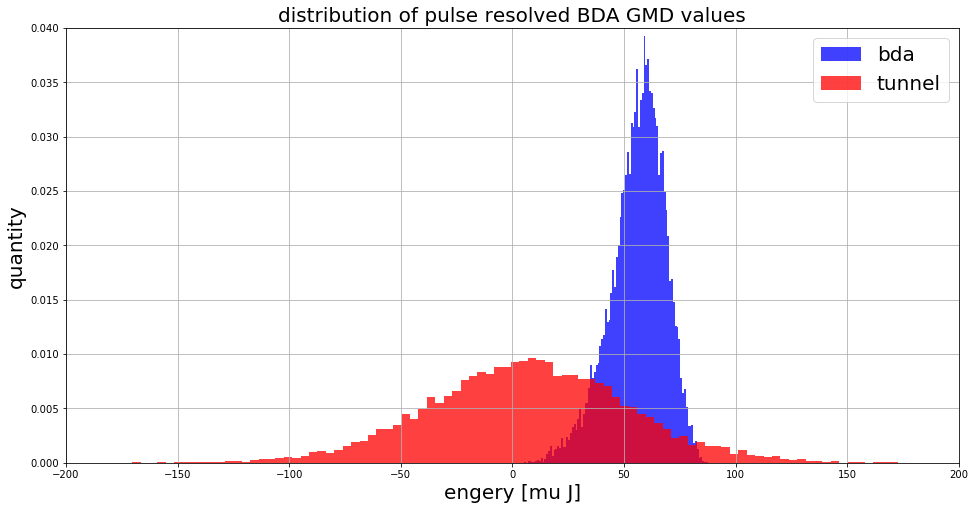

In [7]:
plt.figure(figsize=(16,8))
plt.hist(gmdPulseResBda,100, density= True, facecolor = 'b', alpha=0.75, label = 'bda')
plt.hist(gmdPulseResTunnel,100, density= True, facecolor = 'r', alpha=0.75, label = 'tunnel')
plt.xlabel('engery [mu J]',fontsize = 20)
plt.ylabel('quantity',fontsize = 20)
plt.title('distribution of pulse resolved BDA GMD values', fontsize = 20)
plt.axis([-200, 200, 0, 0.04])
plt.legend(fontsize=20)
plt.grid(True)

### using BDA GMD as the tunnel GMD is mainly Noise (low gas pressure ?) !
RuntimeWarning results from NaNs in pulse resolved GMD dataset

# GMD Correlations

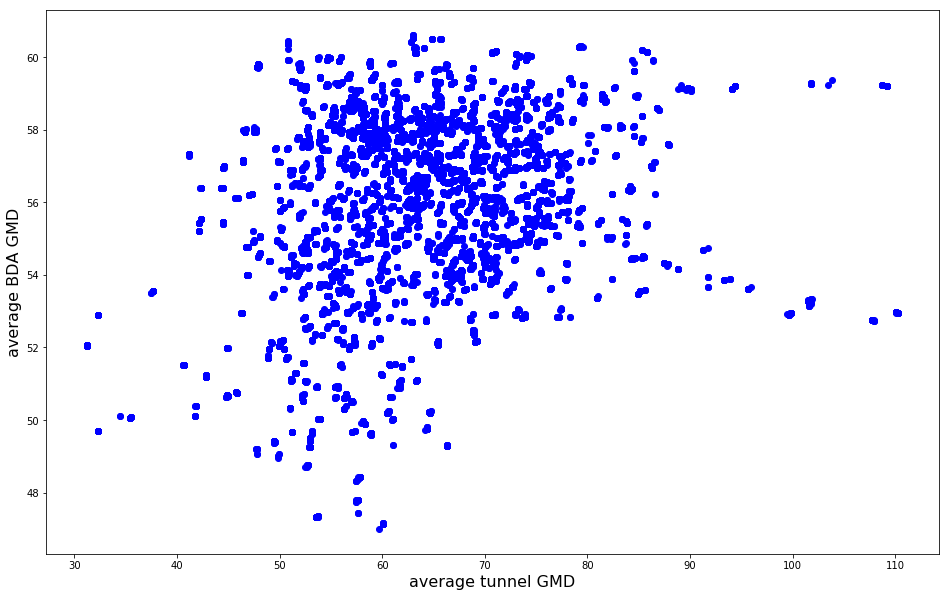

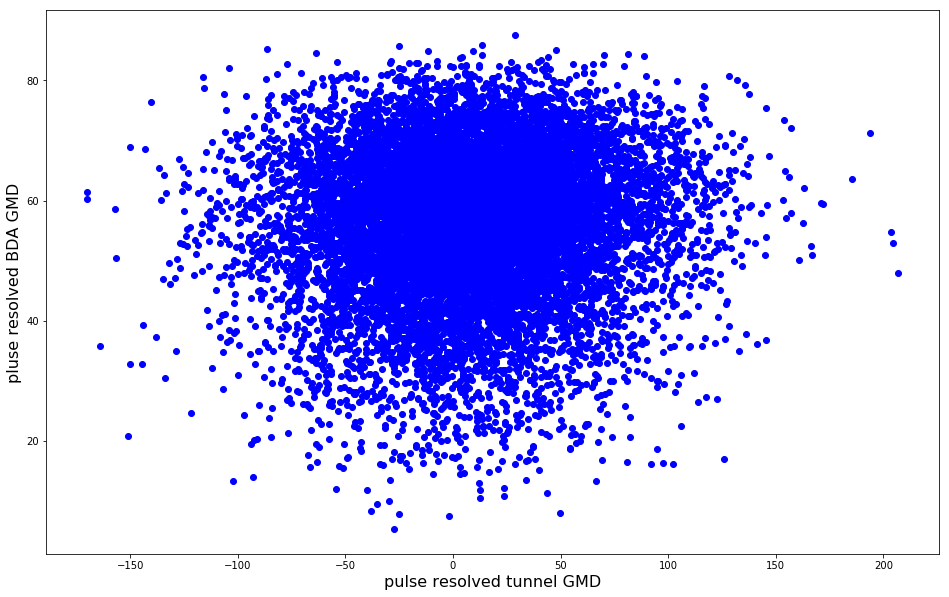

In [8]:
plt.figure(figsize=(16,10))
plt.plot(gmdAveTunnel, gmdAveBda, 'bo')
plt.xlabel('average tunnel GMD', fontsize = 16)
plt.ylabel('average BDA GMD', fontsize = 16);

plt.figure(figsize=(16,10))
plt.plot(gmdPulseResTunnel, gmdPulseResBda, 'bo')
plt.xlabel('pulse resolved tunnel GMD', fontsize = 16)
plt.ylabel('pluse resolved BDA GMD', fontsize = 16)
plt.show()

In [9]:
def calcDensityOfCorrelation(array1, array2, nbins = 300):    
    x = np.asarray([array1[index] for index in range(len(array1)) if array1[index] == array1[index] and array2[index] == array2[index]])
    y = np.asarray([array2[index] for index in range(len(array2)) if array1[index] == array1[index] and array2[index] == array2[index]])
    k = kde.gaussian_kde([x,y])
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    return xi, yi, zi.reshape(xi.shape) 

def plotDensityOfCorrelation(array1, array2, nbins = 300):
    x, y, z = calcDensityOfCorrelation(array1, array2, nbins = 300)
    plt.pcolormesh(x,y,z)

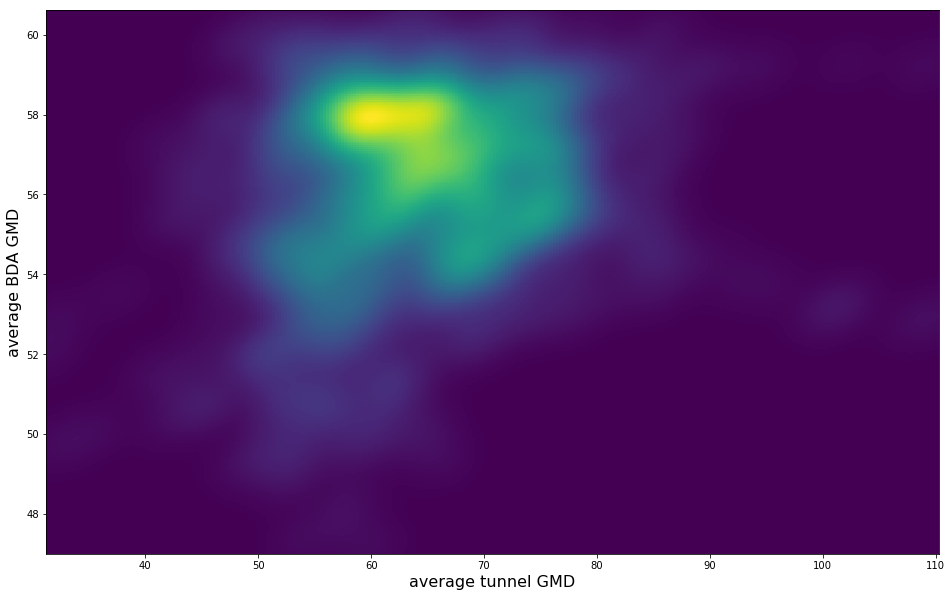

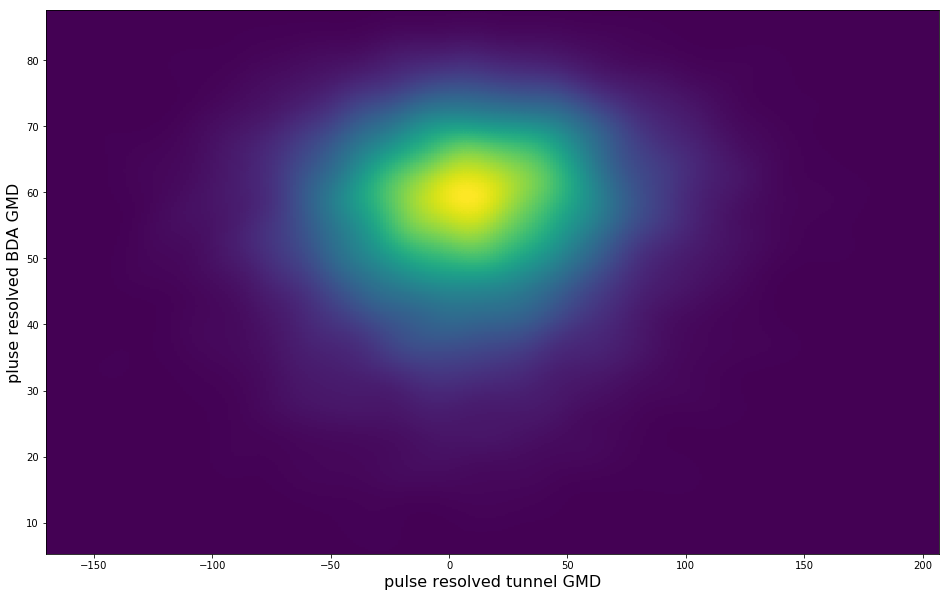

In [10]:
plt.figure(figsize=(16,10))
plotDensityOfCorrelation(gmdAveTunnel.flatten(), gmdAveBda.flatten())
plt.xlabel('average tunnel GMD', fontsize = 16)
plt.ylabel('average BDA GMD', fontsize = 16);

plt.figure(figsize=(16,10))
plotDensityOfCorrelation(gmdPulseResTunnel.flatten(), gmdPulseResBda.flatten())
plt.xlabel('pulse resolved tunnel GMD', fontsize = 16)
plt.ylabel('pluse resolved BDA GMD', fontsize = 16)
plt.show()

# Calculate GAIN to normalize pulse resolved GMD values

https://www-users.cs.york.ac.uk/~fisher/cgi-bin/mkfscript

* Bessel filter 
* corner 1 freq: 0.010 Hz - 0.014 Hz 
* 1 order 
* sample rate: 10

```

std::array<float, size> in{};
std::array<float, size> out{};

in = ... // fill

const double a0 = 0.00500145;
const double a1 = 0.00500145;
const double b1 = 0.989997;

// a0 := a1 := 'fischer' 1/GAIN
// b1 := 1.0 - a0 - a1

for (int i = 1; i < in.size(); ++i) {
  out[i] = a0 * in[i] + a1 * in[i-1] + b1 * out[i-1];
  
```

#### averaged GMD = Ion Signal
#### pulse resolved GMD = Electron Signal

### define filter and filter coefficient

In [11]:
def filterElectronSignal(inputValues):
    a0 = 0.00500145
    a1 = a0
    b1 = 1 - a0 - a1 
    outputValues = []
    for i in range(len(inputValues)):
        if i == 0:
            temp = inputValues[0]
        else:
            temp = a0 * inputValues[i]+a1*inputValues[i-1]+b1*outputValues[i-1]
        outputValues.append(temp)
    return outputValues

## hardware-like filter on pulse resolved GMD values

In [12]:
filteredElectronGmdBda = filterElectronSignal(np.nan_to_num(gmdPulseResBda))

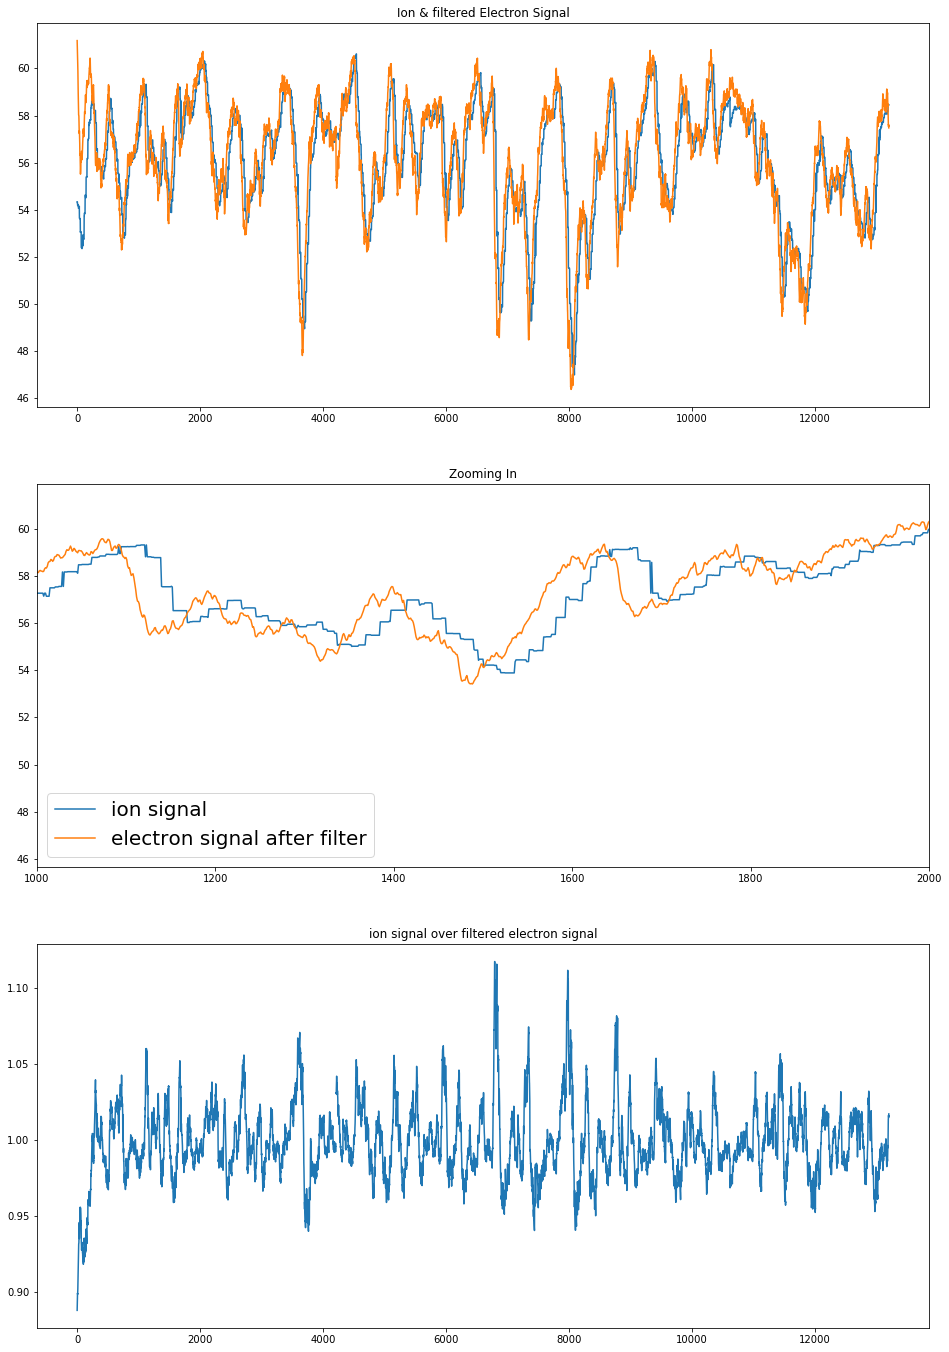

In [13]:
plt.figure(figsize=(16,24))

plt.subplot(311)
plt.plot(gmdAveBda, label = 'ion signal')
plt.plot(filteredElectronGmdBda,  label = 'electron signal after filter')
plt.title('Ion & filtered Electron Signal')

plt.subplot(312)
plt.plot(gmdAveBda, label = 'ion signal')
plt.plot(filteredElectronGmdBda,  label = 'electron signal after filter')
plt.legend(fontsize = 20)
plt.xlim(1000,2000)
plt.title('Zooming In')

plt.subplot(313)
plt.plot(gmdAveBda / filteredElectronGmdBda)
plt.title('ion signal over filtered electron signal');

## Shift Ion Signal to compensate for Keyleigh delay time 

Max:  1.0406642707449385 |  Min:  0.9686382025098333


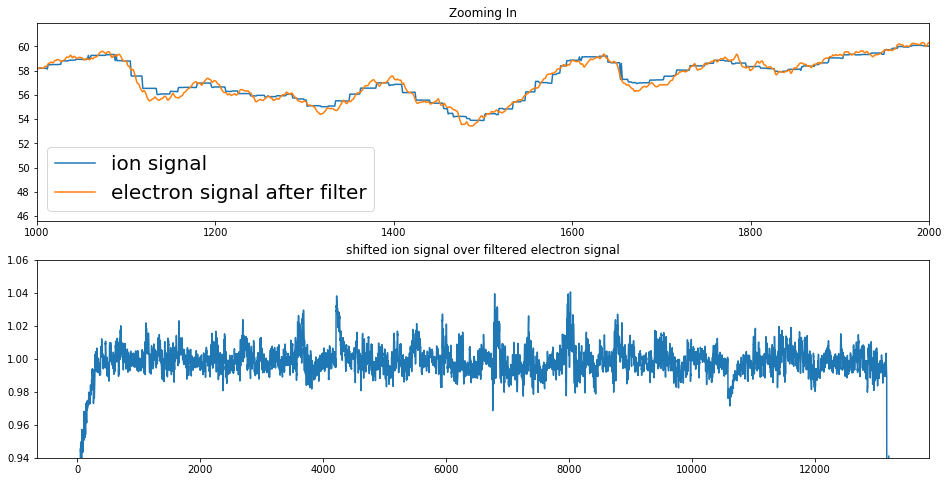

In [14]:
shift = -34
newGmdAveBda =np.roll(gmdAveBda, shift)
ratioIonFilteredElectronSignal = newGmdAveBda / filteredElectronGmdBda

plt.figure(figsize=(16,8))

plt.subplot(211)
plt.plot(newGmdAveBda, label = 'ion signal')
plt.plot(filteredElectronGmdBda,  label = 'electron signal after filter')
plt.legend(fontsize = 20)
plt.xlim(1000,2000)
plt.title('Zooming In')

plt.subplot(212)
plt.plot(ratioIonFilteredElectronSignal)
plt.ylim(0.94,1.06)
plt.title('shifted ion signal over filtered electron signal')

print('Max: ',np.nanmax(ratioIonFilteredElectronSignal[1000:12500]),'|  Min: ',np.nanmin(ratioIonFilteredElectronSignal[1000:12500]))

## Check for Improvment via Correlation

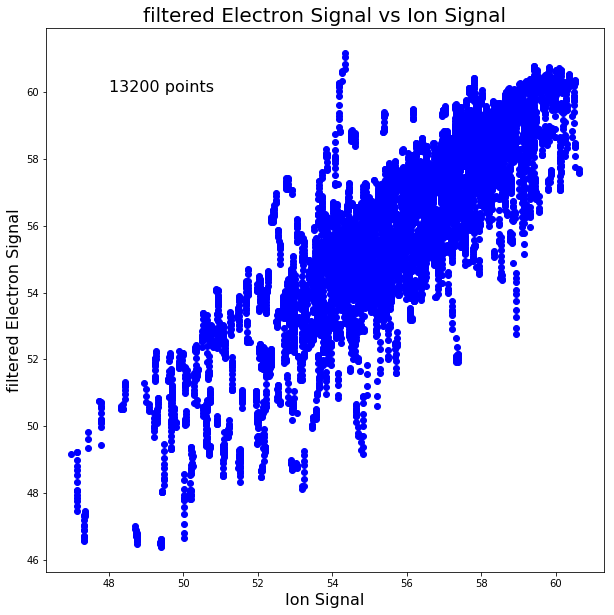

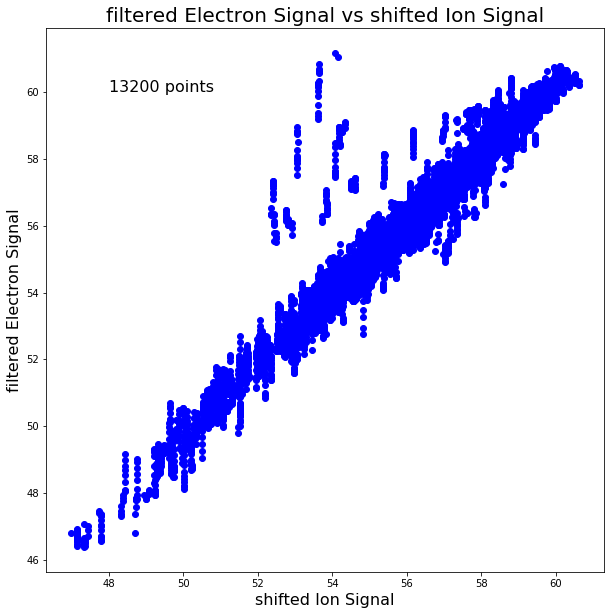

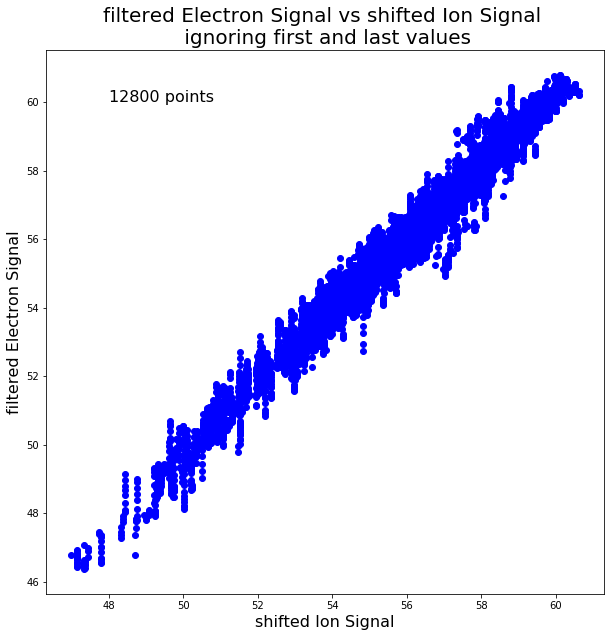

In [15]:
plt.figure(figsize=(10,10))
plt.plot(gmdAveBda, filteredElectronGmdBda, 'bo')
plt.xlabel('Ion Signal', fontsize = 16)
plt.ylabel('filtered Electron Signal', fontsize = 16)
plt.title('filtered Electron Signal vs Ion Signal', fontsize = 20)
plt.text(48,60,'{} points'.format(len(gmdAveBda)), fontsize=16)



plt.figure(figsize=(10,10))
plt.plot(newGmdAveBda, filteredElectronGmdBda, 'bo')
plt.xlabel('shifted Ion Signal', fontsize = 16)
plt.ylabel('filtered Electron Signal', fontsize = 16)
plt.title('cut Values at the Start and End of DataSet', fontsize = 20)
plt.title('filtered Electron Signal vs shifted Ion Signal', fontsize = 20)
plt.text(48,60,'{} points'.format(len(gmdAveBda)), fontsize=16)

cutOff = 200

plt.figure(figsize=(10,10))
plt.plot(newGmdAveBda[cutOff:-cutOff], filteredElectronGmdBda[cutOff:-cutOff], 'bo')
plt.xlabel('shifted Ion Signal', fontsize = 16)
plt.ylabel('filtered Electron Signal', fontsize = 16)
plt.title('filtered Electron Signal vs shifted Ion Signal \n ignoring first and last values', fontsize = 20)
plt.text(48,60,'{} points'.format(len(newGmdAveBda[cutOff:-cutOff])), fontsize=16);